In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import pandas as pd
import os
import glob
import re
import seaborn as sns
from tqdm.notebook import tqdm
from scipy.stats import pearsonr

import sys
sys.path.append("..")
import utils.utils as utils
import utils.pos_utils as pos_utils
import utils.postprocessing_utils as post_utils

In [9]:
results_pos = post_utils.retrieve_results("../results/results_pos_postprocessed.xlsx", 3)
langvlang_pos = results_pos["Accuracy"]["langvlang"]
langvgroup_pos = results_pos["Accuracy"]["langvgroup"]

results_sentiment = post_utils.retrieve_results("../results/results_sentiment_postprocessed.xlsx", 3)
langvlang_sentiment = results_sentiment["Macro_F1"]["langvlang"]
langvgroup_sentiment = results_sentiment["Macro_F1"]["langvgroup"]

In [10]:
df_pos = pd.DataFrame({"Train-Group": langvlang_pos.iloc[:15, 0], "Train-Language": langvlang_pos.columns[2:-1], 
                   "Within-Accuracy": np.diagonal(langvlang_pos.iloc[:15, 2:-1].values)})
df_group_pos = langvgroup_pos.iloc[:4, [True] + [False] + [True]*15 + [False]]
df_group_pos = pd.melt(df_group_pos.rename(columns={"Test\Train": "Test-Group"}), id_vars="Test-Group", 
                   value_vars=df_group_pos.columns[1:], 
                   var_name="Train-Language", value_name="Cross-Accuracy")

df_sentiment = pd.DataFrame({"Train-Group": langvlang_sentiment.iloc[:12, 0], 
                             "Train-Language": langvlang_sentiment.columns[2:-1], 
                             "Within-Macro-F1": np.diagonal(langvlang_sentiment.iloc[:12, 2:-1].values)})
df_group_sentiment = langvgroup_sentiment.iloc[:4, [True, False] + [True] * 12 + [False]]
df_group_sentiment = pd.melt(df_group_sentiment.rename(columns={"Test\Train": "Test-Group"}), id_vars="Test-Group", 
                   value_vars=df_group_sentiment.columns[1:], 
                   var_name="Train-Language", value_name="Cross-Macro-F1")

In [11]:
transfer_pos = pd.merge(df_pos, df_group_pos, on="Train-Language")
transfer_pos = transfer_pos[transfer_pos["Train-Language"] != "Thai"].reset_index(drop=True)
transfer_pos["Cross-Accuracy"] = transfer_pos["Cross-Accuracy"].astype(float) * 100
transfer_pos["Within-Accuracy"] = transfer_pos["Within-Accuracy"].astype(float) * 100
transfer_pos["Transfer-Loss"] = transfer_pos["Within-Accuracy"] - transfer_pos["Cross-Accuracy"]

transfer_sentiment = pd.merge(df_sentiment, df_group_sentiment, on="Train-Language")
transfer_sentiment["Cross-Macro-F1"] = transfer_sentiment["Cross-Macro-F1"].astype(float)
transfer_sentiment["Within-Macro-F1"] = transfer_sentiment["Within-Macro-F1"].astype(float)
transfer_sentiment["Transfer-Loss"] = transfer_sentiment["Within-Macro-F1"] - transfer_sentiment["Cross-Macro-F1"]

In [12]:
final_pos = transfer_pos[transfer_pos["Test-Group"] != transfer_pos["Train-Group"]].groupby(by=["Train-Group", 
                                                                                                "Train-Language"], 
                                                                    as_index=False, sort=False).mean()
final_pos["Test-Group"] = "Others"
temp_pos = transfer_pos[transfer_pos["Test-Group"] == transfer_pos["Train-Group"]].copy()
temp_pos.loc[:, "Test-Group"] = "Same"
final_pos = pd.concat([final_pos, temp_pos], ignore_index=True)
final_pos["sort"] = np.concatenate((np.arange(1, 28, 2), np.arange(0, 28, 2)))
final_pos = final_pos.sort_values("sort").reset_index(drop=True).drop("sort", axis=1)
final_pos["Relative-Transfer-Loss"] = final_pos["Transfer-Loss"] / final_pos["Within-Accuracy"] * 100

final_sentiment = transfer_sentiment[transfer_sentiment["Test-Group"] != transfer_sentiment["Train-Group"]].groupby(
    by=["Train-Group", "Train-Language"], as_index=False, sort=False
).mean()
final_sentiment["Test-Group"] = "Others"
temp_sentiment = transfer_sentiment[transfer_sentiment["Test-Group"] == transfer_sentiment["Train-Group"]].copy()
temp_sentiment.loc[:, "Test-Group"] = "Same"
final_sentiment = pd.concat([final_sentiment, temp_sentiment], ignore_index=True)
final_sentiment["sort"] = np.concatenate((np.arange(1, 24, 2), np.arange(0, 24, 2)))
final_sentiment = final_sentiment.sort_values("sort").reset_index(drop=True).drop("sort", axis=1)
final_sentiment["Relative-Transfer-Loss"] = final_sentiment["Transfer-Loss"] / final_sentiment["Within-Macro-F1"] * 100

In [30]:
final_avg_pos = final_pos.groupby(by=["Train-Group", "Test-Group"], as_index=False, sort=False).mean()
total_pos = final_avg_pos.groupby("Test-Group", as_index=False, sort=False).mean()
total_pos.insert(0, "Train-Group", ["TOTAL"]*2)
final_avg_pos = pd.concat([final_avg_pos, total_pos])
final_avg_pos["Test-Group"] = "PoS-" + final_avg_pos["Test-Group"]

final_avg_sentiment = final_sentiment.groupby(by=["Train-Group", "Test-Group"], as_index=False, sort=False).mean()
total_sentiment = final_avg_sentiment.groupby("Test-Group", as_index=False, sort=False).mean()
total_sentiment.insert(0, "Train-Group", ["TOTAL"]*2)
final_avg_sentiment = pd.concat([final_avg_sentiment, total_sentiment])
final_avg_sentiment["Test-Group"] = "Sentiment-" + final_avg_sentiment["Test-Group"]

In [31]:
final_avg = pd.concat([final_avg_pos, final_avg_sentiment]).reset_index(drop=True)

In [64]:
diff = final_avg.loc[final_avg["Test-Group"].str.endswith("Others"), "Relative-Transfer-Loss"].reset_index(drop=True) \
- final_avg.loc[final_avg["Test-Group"].str.endswith("Same"), "Relative-Transfer-Loss"].reset_index(drop=True)

In [66]:
diff_df = pd.DataFrame({"Train-Group": final_avg["Train-Group"].unique().tolist() * 2, 
              "Test-Group": np.array(["PoS"] * 5 + ["Sentiment"] * 5, dtype=object) + np.array(["-Difference"], dtype=object),
              "Relative-Transfer-Loss": diff})

In [69]:
final_avg = pd.concat([final_avg, diff_df], ignore_index=True)

In [77]:
final_avg = pd.concat([final_avg, pd.DataFrame({"Train-Group": final_avg["Train-Group"].unique(),
                                                "Test-Group": "sep",
                                                "Relative-Transfer-Loss": [0]*5})], ignore_index=True)

In [100]:
final_avg["Task"] = final_avg["Test-Group"].apply(lambda x: x.split("-")[0])

In [104]:
final_avg["Test"] = final_avg["Test-Group"].apply(lambda x: x.split("-")[-1])

In [84]:
sns.set()
sns.set_style("ticks")
plt.rc("xtick", labelsize=16)
plt.rc("ytick", labelsize=16)
plt.rc("axes", labelsize=16)
plt.rcParams["text.usetex"] = True

In [139]:
test_order = ["PoS-Same", "Sentiment-Same", "PoS-Others", "Sentiment-Others", "PoS-Difference", "Sentiment-Difference", "sep"]
train_order = ["Fusional", "Isolating", "Agglutinative", "Introflexive", "TOTAL"]

In [141]:
final_avg["sort"] = final_avg.apply(lambda x: train_order.index(x["Train-Group"]) * 8 + test_order.index(x["Test-Group"]), 
                                    axis=1)

In [147]:
final_avg = final_avg.sort_values("sort").reset_index(drop=True)

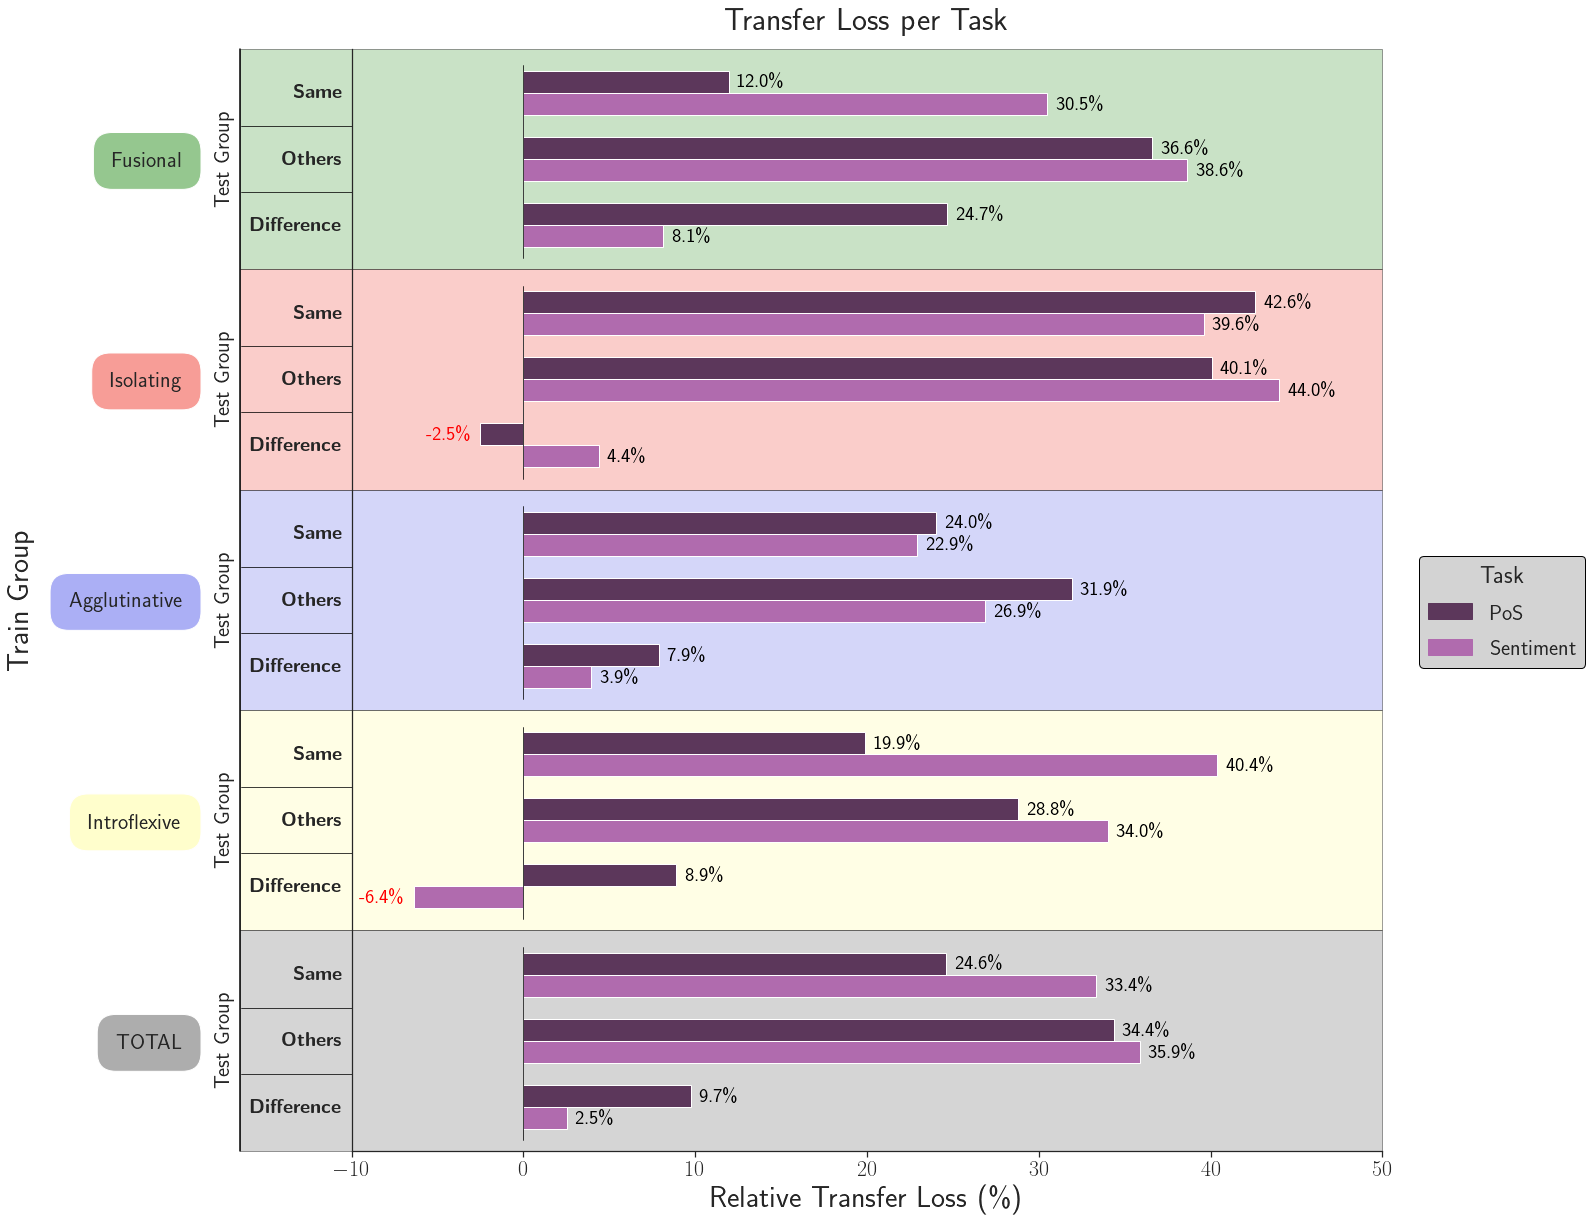

In [364]:
def scale_y(y, groups):
    return 1 - y / len(groups)

colors = ["#95c78f", "#f79d97", "#abaff5", "#fffecc", "#adadad"]
bar_colors = {"PoS-Same": "#870c85", "PoS-Others": "#870c85", "PoS-Difference": "#870c85", 
              "Sentiment-Same": "#ff1cfb", "Sentiment-Others": "#ff1cfb", "Sentiment-Difference": "#ff1cfb",
              "sep": "white"}
extra_fontsize = 2

g = sns.catplot(
    data=final_avg, kind="bar", x="Relative-Transfer-Loss", y="Train-Group", hue="Test-Group",
    hue_order=["PoS-Same", "Sentiment-Same", "sep", 
               "PoS-Others", "Sentiment-Others", "sep",
               "PoS-Difference", "Sentiment-Difference"],
    height=16, aspect=1, palette=bar_colors, saturation=0.3, legend=False
)

groups = final_avg["Train-Group"].unique().tolist()

for group in groups:
    values = final_avg.loc[(final_avg["Train-Group"] == group), "Relative-Transfer-Loss"].values[:-1]
    dy = [-0.35, -0.25, -0.05, 0.05, 0.25, 0.35]
    for i in range(len(values)):
        # Bar values
        p = "{:.1f}\%".format(values[i])
        if values[i] >= 0:
            dx = 0.5
            align = "left"
            color = "black"
        else:
            dx = -0.5
            align = "right"
            color = "red"
        g.ax.text(values[i] + dx, groups.index(group) + dy[i], p, 
                  verticalalignment="center", horizontalalignment=align, 
                  fontsize=18 + extra_fontsize, color=color)
        
    # Line at 0
    plt.axvline(x=0, ymin=scale_y(groups.index(group) + 1 - 0.05, groups), 
                ymax=scale_y(groups.index(group) + 1 - 0.925, groups), 
                color="black", linewidth=0.75)
    
    # Test group labels and lines
    for y, test in zip([-0.3, 0, 0.3], final_avg["Test"].unique()[:-1]):
        plt.annotate(r"\textbf{{{}}}".format(test), (-10, groups.index(group) + y), xytext=(-10.5, groups.index(group) + y),
                     fontsize=20, verticalalignment="center", horizontalalignment="right")
        if test != "Difference":
            plt.axhline(y=groups.index(group) + y + 0.15, xmin=-0.1075, xmax=0, clip_on=False, color="black", linewidth=0.75)
        
    # Background color
    background = patches.Rectangle((-16.5, -0.5 + groups.index(group)), 66.5, 1, fill=True, color=colors[groups.index(group)], 
                                   alpha=0.5, ec="black", zorder=0, linewidth=0.75, clip_on=False)
    g.ax.add_patch(background)
    
    # Y axis sublabel
    plt.annotate("Test Group", (-10, groups.index(group) + y), xytext=(-18, groups.index(group)), rotation=90,
                 fontsize=22, verticalalignment="center")

# Y labels
for i, label in enumerate(g.ax.yaxis.get_ticklabels()):
    label.set_bbox(dict(boxstyle="round,pad=0.85",
                             fc=colors[i]))
    position = label.get_position()
    label.set_position((position[0] - 0.155, position[1]))
    
# Other lines
plt.axvline(-16.5, clip_on=False, color="black")
    
# Legend
handles = [patches.Rectangle((0,0), 1, 1, color=sns.desaturate("#870c85", 0.3)), 
           patches.Rectangle((0,0), 1, 1, color=sns.desaturate("#ff1cfb", 0.3))]
plt.legend(title="Task", handles=handles, labels=["PoS", "Sentiment"], title_fontsize=22 + extra_fontsize, loc="upper left", 
           bbox_to_anchor=(1.025, 0.55), fontsize=20 + extra_fontsize, facecolor="lightgrey", 
           framealpha=1, edgecolor="black", labelspacing=0.7)

plt.xlim((-10, 50))
plt.ylabel("Train Group", fontsize=28 + extra_fontsize, labelpad=35)
plt.xlabel("Relative Transfer Loss (\%)", fontsize=28 +  extra_fontsize)
plt.title("Transfer Loss per Task", 
          fontsize=30 + extra_fontsize, pad=20)
plt.tick_params(labelsize=20 + extra_fontsize)
plt.tick_params(axis="y", which="both", left=False)

sns.despine(g.fig)

#plt.savefig("../results/plots/task_transfer_loss_groups.pdf", dpi=400, bbox_inches="tight")
plt.show()
plt.close()

### Balanced Length

In [2]:
results_pos = post_utils.retrieve_results("../results/balanced_length/results_pos_postprocessed_balanced_length.xlsx", 3)
langvlang_pos = results_pos["Accuracy"]["langvlang"]
langvgroup_pos = results_pos["Accuracy"]["langvgroup"]

results_sentiment = post_utils.retrieve_results("../results/balanced_length/results_sentiment_postprocessed_balanced_length.xlsx", 3)
langvlang_sentiment = results_sentiment["Macro_F1"]["langvlang"]
langvgroup_sentiment = results_sentiment["Macro_F1"]["langvgroup"]

In [3]:
df_pos = pd.DataFrame({"Train-Group": langvlang_pos.iloc[:15, 0], "Train-Language": langvlang_pos.columns[2:-1], 
                   "Within-Accuracy": np.diagonal(langvlang_pos.iloc[:15, 2:-1].values)})
df_group_pos = langvgroup_pos.iloc[:4, [True] + [False] + [True]*15 + [False]]
df_group_pos = pd.melt(df_group_pos.rename(columns={"Test\Train": "Test-Group"}), id_vars="Test-Group", 
                   value_vars=df_group_pos.columns[1:], 
                   var_name="Train-Language", value_name="Cross-Accuracy")

df_sentiment = pd.DataFrame({"Train-Group": langvlang_sentiment.iloc[:12, 0], 
                             "Train-Language": langvlang_sentiment.columns[2:-1], 
                             "Within-Macro-F1": np.diagonal(langvlang_sentiment.iloc[:12, 2:-1].values)})
df_group_sentiment = langvgroup_sentiment.iloc[:4, [True, False] + [True] * 12 + [False]]
df_group_sentiment = pd.melt(df_group_sentiment.rename(columns={"Test\Train": "Test-Group"}), id_vars="Test-Group", 
                   value_vars=df_group_sentiment.columns[1:], 
                   var_name="Train-Language", value_name="Cross-Macro-F1")

In [4]:
transfer_pos = pd.merge(df_pos, df_group_pos, on="Train-Language")
transfer_pos = transfer_pos[transfer_pos["Train-Language"] != "Thai"].reset_index(drop=True)
transfer_pos["Cross-Accuracy"] = transfer_pos["Cross-Accuracy"].astype(float) * 100
transfer_pos["Within-Accuracy"] = transfer_pos["Within-Accuracy"].astype(float) * 100
transfer_pos["Transfer-Loss"] = transfer_pos["Within-Accuracy"] - transfer_pos["Cross-Accuracy"]

transfer_sentiment = pd.merge(df_sentiment, df_group_sentiment, on="Train-Language")
transfer_sentiment["Cross-Macro-F1"] = transfer_sentiment["Cross-Macro-F1"].astype(float)
transfer_sentiment["Within-Macro-F1"] = transfer_sentiment["Within-Macro-F1"].astype(float)
transfer_sentiment["Transfer-Loss"] = transfer_sentiment["Within-Macro-F1"] - transfer_sentiment["Cross-Macro-F1"]

In [5]:
final_pos = transfer_pos[transfer_pos["Test-Group"] != transfer_pos["Train-Group"]].groupby(by=["Train-Group", 
                                                                                                "Train-Language"], 
                                                                    as_index=False, sort=False).mean()
final_pos["Test-Group"] = "Others"
temp_pos = transfer_pos[transfer_pos["Test-Group"] == transfer_pos["Train-Group"]].copy()
temp_pos.loc[:, "Test-Group"] = "Same"
final_pos = pd.concat([final_pos, temp_pos], ignore_index=True)
final_pos["sort"] = np.concatenate((np.arange(1, 28, 2), np.arange(0, 28, 2)))
final_pos = final_pos.sort_values("sort").reset_index(drop=True).drop("sort", axis=1)
final_pos["Relative-Transfer-Loss"] = final_pos["Transfer-Loss"] / final_pos["Within-Accuracy"] * 100

final_sentiment = transfer_sentiment[transfer_sentiment["Test-Group"] != transfer_sentiment["Train-Group"]].groupby(
    by=["Train-Group", "Train-Language"], as_index=False, sort=False
).mean()
final_sentiment["Test-Group"] = "Others"
temp_sentiment = transfer_sentiment[transfer_sentiment["Test-Group"] == transfer_sentiment["Train-Group"]].copy()
temp_sentiment.loc[:, "Test-Group"] = "Same"
final_sentiment = pd.concat([final_sentiment, temp_sentiment], ignore_index=True)
final_sentiment["sort"] = np.concatenate((np.arange(1, 24, 2), np.arange(0, 24, 2)))
final_sentiment = final_sentiment.sort_values("sort").reset_index(drop=True).drop("sort", axis=1)
final_sentiment["Relative-Transfer-Loss"] = final_sentiment["Transfer-Loss"] / final_sentiment["Within-Macro-F1"] * 100

In [6]:
final_avg_pos = final_pos.groupby(by=["Train-Group", "Test-Group"], as_index=False, sort=False).mean()
total_pos = final_avg_pos.groupby("Test-Group", as_index=False, sort=False).mean()
total_pos.insert(0, "Train-Group", ["TOTAL"]*2)
final_avg_pos = pd.concat([final_avg_pos, total_pos])
final_avg_pos["Test-Group"] = "PoS-" + final_avg_pos["Test-Group"]

final_avg_sentiment = final_sentiment.groupby(by=["Train-Group", "Test-Group"], as_index=False, sort=False).mean()
total_sentiment = final_avg_sentiment.groupby("Test-Group", as_index=False, sort=False).mean()
total_sentiment.insert(0, "Train-Group", ["TOTAL"]*2)
final_avg_sentiment = pd.concat([final_avg_sentiment, total_sentiment])
final_avg_sentiment["Test-Group"] = "Sentiment-" + final_avg_sentiment["Test-Group"]

In [7]:
final_avg = pd.concat([final_avg_pos, final_avg_sentiment]).reset_index(drop=True)

In [8]:
diff = final_avg.loc[final_avg["Test-Group"].str.endswith("Others"), "Relative-Transfer-Loss"].reset_index(drop=True) \
- final_avg.loc[final_avg["Test-Group"].str.endswith("Same"), "Relative-Transfer-Loss"].reset_index(drop=True)

In [9]:
diff_df = pd.DataFrame({"Train-Group": final_avg["Train-Group"].unique().tolist() * 2, 
              "Test-Group": np.array(["PoS"] * 5 + ["Sentiment"] * 5, dtype=object) + np.array(["-Difference"], dtype=object),
              "Relative-Transfer-Loss": diff})

In [10]:
final_avg = pd.concat([final_avg, diff_df], ignore_index=True)

In [11]:
final_avg = pd.concat([final_avg, pd.DataFrame({"Train-Group": final_avg["Train-Group"].unique(),
                                                "Test-Group": "sep",
                                                "Relative-Transfer-Loss": [0]*5})], ignore_index=True)

In [12]:
final_avg["Task"] = final_avg["Test-Group"].apply(lambda x: x.split("-")[0])

In [13]:
final_avg["Test"] = final_avg["Test-Group"].apply(lambda x: x.split("-")[-1])

In [14]:
sns.set()
sns.set_style("ticks")
plt.rc("xtick", labelsize=16)
plt.rc("ytick", labelsize=16)
plt.rc("axes", labelsize=16)
plt.rcParams["text.usetex"] = True

In [15]:
test_order = ["PoS-Same", "Sentiment-Same", "PoS-Others", "Sentiment-Others", "PoS-Difference", "Sentiment-Difference", "sep"]
train_order = ["Fusional", "Isolating", "Agglutinative", "Introflexive", "TOTAL"]

In [16]:
final_avg["sort"] = final_avg.apply(lambda x: train_order.index(x["Train-Group"]) * 8 + test_order.index(x["Test-Group"]), 
                                    axis=1)

In [17]:
final_avg = final_avg.sort_values("sort").reset_index(drop=True)

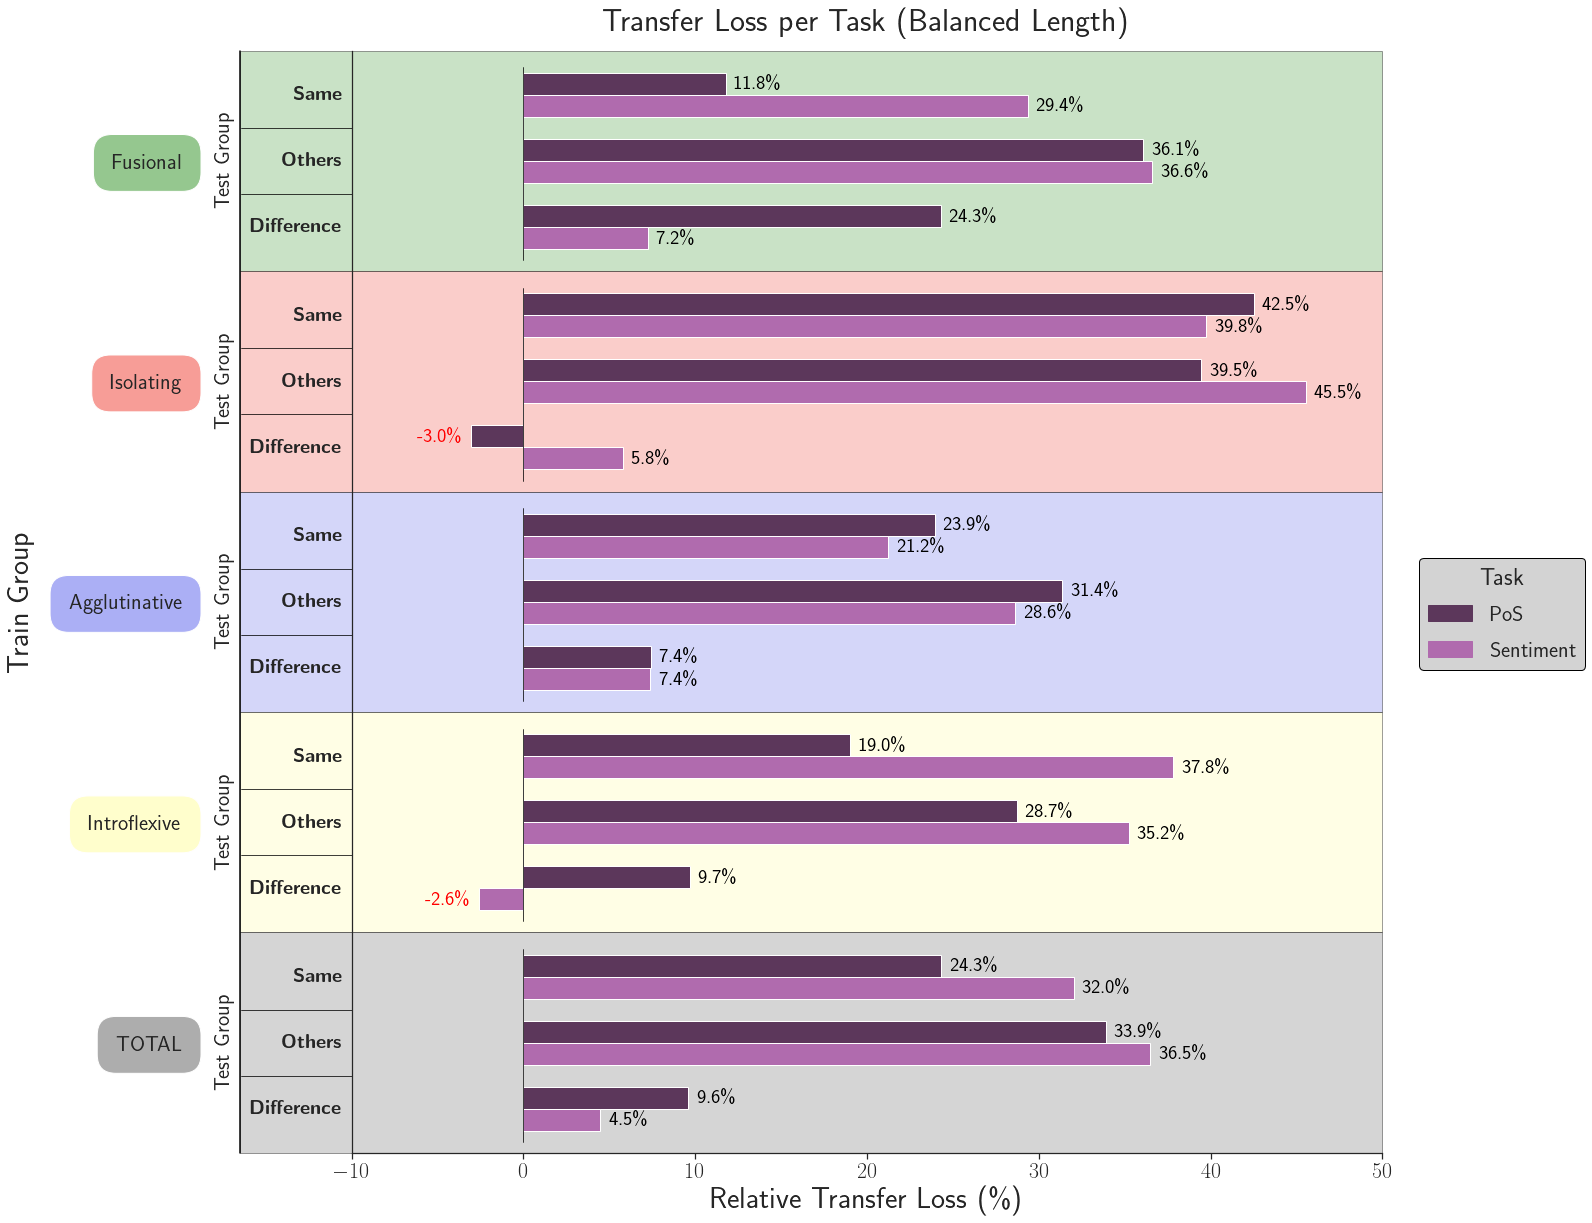

In [20]:
def scale_y(y, groups):
    return 1 - y / len(groups)

colors = ["#95c78f", "#f79d97", "#abaff5", "#fffecc", "#adadad"]
bar_colors = {"PoS-Same": "#870c85", "PoS-Others": "#870c85", "PoS-Difference": "#870c85", 
              "Sentiment-Same": "#ff1cfb", "Sentiment-Others": "#ff1cfb", "Sentiment-Difference": "#ff1cfb",
              "sep": "white"}
extra_fontsize = 2

g = sns.catplot(
    data=final_avg, kind="bar", x="Relative-Transfer-Loss", y="Train-Group", hue="Test-Group",
    hue_order=["PoS-Same", "Sentiment-Same", "sep", 
               "PoS-Others", "Sentiment-Others", "sep",
               "PoS-Difference", "Sentiment-Difference"],
    height=16, aspect=1, palette=bar_colors, saturation=0.3, legend=False
)

groups = final_avg["Train-Group"].unique().tolist()

for group in groups:
    values = final_avg.loc[(final_avg["Train-Group"] == group), "Relative-Transfer-Loss"].values[:-1]
    dy = [-0.35, -0.25, -0.05, 0.05, 0.25, 0.35]
    for i in range(len(values)):
        # Bar values
        p = "{:.1f}\%".format(values[i])
        if values[i] >= 0:
            dx = 0.5
            align = "left"
            color = "black"
        else:
            dx = -0.5
            align = "right"
            color = "red"
        g.ax.text(values[i] + dx, groups.index(group) + dy[i], p, 
                  verticalalignment="center", horizontalalignment=align, 
                  fontsize=18 + extra_fontsize, color=color)
        
    # Line at 0
    plt.axvline(x=0, ymin=scale_y(groups.index(group) + 1 - 0.05, groups), 
                ymax=scale_y(groups.index(group) + 1 - 0.925, groups), 
                color="black", linewidth=0.75)
    
    # Test group labels and lines
    for y, test in zip([-0.3, 0, 0.3], final_avg["Test"].unique()[:-1]):
        plt.annotate(r"\textbf{{{}}}".format(test), (-10, groups.index(group) + y), xytext=(-10.5, groups.index(group) + y),
                     fontsize=20, verticalalignment="center", horizontalalignment="right")
        if test != "Difference":
            plt.axhline(y=groups.index(group) + y + 0.15, xmin=-0.1075, xmax=0, clip_on=False, color="black", linewidth=0.75)
        
    # Background color
    background = patches.Rectangle((-16.5, -0.5 + groups.index(group)), 66.5, 1, fill=True, color=colors[groups.index(group)], 
                                   alpha=0.5, ec="black", zorder=0, linewidth=0.75, clip_on=False)
    g.ax.add_patch(background)
    
    # Y axis sublabel
    plt.annotate("Test Group", (-10, groups.index(group) + y), xytext=(-18, groups.index(group)), rotation=90,
                 fontsize=22, verticalalignment="center")

# Y labels
for i, label in enumerate(g.ax.yaxis.get_ticklabels()):
    label.set_bbox(dict(boxstyle="round,pad=0.85",
                             fc=colors[i]))
    position = label.get_position()
    label.set_position((position[0] - 0.155, position[1]))
    
# Other lines
plt.axvline(-16.5, clip_on=False, color="black")
    
# Legend
handles = [patches.Rectangle((0,0), 1, 1, color=sns.desaturate("#870c85", 0.3)), 
           patches.Rectangle((0,0), 1, 1, color=sns.desaturate("#ff1cfb", 0.3))]
plt.legend(title="Task", handles=handles, labels=["PoS", "Sentiment"], title_fontsize=22 + extra_fontsize, loc="upper left", 
           bbox_to_anchor=(1.025, 0.55), fontsize=20 + extra_fontsize, facecolor="lightgrey", 
           framealpha=1, edgecolor="black", labelspacing=0.7)

plt.xlim((-10, 50))
plt.ylabel("Train Group", fontsize=28 + extra_fontsize, labelpad=35)
plt.xlabel("Relative Transfer Loss (\%)", fontsize=28 +  extra_fontsize)
plt.title("Transfer Loss per Task (Balanced Length)", 
          fontsize=30 + extra_fontsize, pad=20)
plt.tick_params(labelsize=20 + extra_fontsize)
plt.tick_params(axis="y", which="both", left=False)

sns.despine(g.fig)

#plt.savefig("../results/plots/task_transfer_loss_groups_balanced_length.pdf", dpi=400, bbox_inches="tight")
plt.show()
plt.close()